# CMSC 320 Final Project:
# Is Height an Advantage in Professional Tennis?
### Author: Eric Li

# Introduction

In this project, I analyzed data from the ATP (Association of Tennis Professionals) Tour in order to find out if physical attributes such as height and dominant hand have a significant effect on a player's success. Height is often considered to be a major advantage in tennis, as taller players are typically able to generate more speed and power on their serves than shorter players. Being left-handed is also considered to be an advantage as most players are usually able to generate more heavy topspin on their forehand rather than their backhand, and left-handed players take advantage of this fact by hitting cross-court to a right-handed player's backhand in order to better control points. This is an effective strategy because most right-handed players are use to playing against other right-handed players, so playing against a left-handed player can be more uncomfortable for them.

In order to test these theories, I will analyze ATP match data from the last 5 years (2018-2022) using a variety of methods, including linear regression and hypothesis testing.

For those that are not familiar with the rules of tennis, here is a basic introduction: https://www.rulesofsport.com/sports/tennis.html

# Part 1: Data Collection

I obtained my dataset from a GitHub repository of ATP match data dating back to 1968. The dataset that I used includes every ATP level match from 2022, including information about the height, dominant hand, score, date, and ranking of the winner and loser from each match.

The datasets can be found here: https://github.com/JeffSackmann/tennis_atp

Load the required packages.

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import scipy.stats as ss

Read in the CSV file for each year from 2018-2022. Then concatenate them together.

In [155]:
atp_matches_22 = pd.read_csv('match_data/atp_matches_2022.csv')
atp_matches_21 = pd.read_csv('match_data/atp_matches_2021.csv')
atp_matches_20 = pd.read_csv('match_data/atp_matches_2020.csv')
atp_matches_19 = pd.read_csv('match_data/atp_matches_2019.csv')
atp_matches_18 = pd.read_csv('match_data/atp_matches_2018.csv')
atp_matches_18_22 = pd.concat([atp_matches_18, atp_matches_19, atp_matches_20, atp_matches_21, atp_matches_22], axis=0)
atp_matches_18_22.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2018-M020,Brisbane,Hard,32,A,20180101,271,105992,NaN,NaN,...,47.0,33.0,19.0,14.0,1.0,4.0,47.0,1010.0,52.0,909.0
1,2018-M020,Brisbane,Hard,32,A,20180101,272,111577,NaN,NaN,...,41.0,25.0,7.0,9.0,7.0,11.0,54.0,890.0,94.0,593.0
2,2018-M020,Brisbane,Hard,32,A,20180101,273,104797,NaN,NaN,...,53.0,37.0,29.0,15.0,10.0,16.0,63.0,809.0,30.0,1391.0
3,2018-M020,Brisbane,Hard,32,A,20180101,275,200282,NaN,WC,...,43.0,33.0,17.0,11.0,4.0,6.0,208.0,245.0,44.0,1055.0
4,2018-M020,Brisbane,Hard,32,A,20180101,276,111581,NaN,Q,...,35.0,28.0,5.0,9.0,0.0,2.0,175.0,299.0,68.0,755.0


In [156]:
atp_matches_18_22.shape

(12814, 49)

The dataset contains information about 12814 ATP matches from 2018-2022.

# Part 2: Data Pre-Processing

In this part, I will create a new dataframe with information about each player's win percentage over the past five years, along with their height, dominant hand, and match statistics.

Let's first create a new dataframe by counting the number of instances of each unique name in the "winner_name" column, then resetting the indexes and renaming the count column to "wins", as this value represents the number of matches each player has won over the past five years.

Note: This is possible to do because we are assuming that a player's height and dominant hand stays constant throughout this period of time. In this case, we are also only looking at players that have won at least one match in the past five years.

In [158]:
player_data = atp_matches_18_22.groupby(['winner_name','winner_hand','winner_ht']).size().reset_index().rename(columns={0:'wins'})
player_data = player_data.rename(columns={'winner_name':'name', 'winner_hand':'hand', 'winner_ht':'height'})
player_data.head()

,name,hand,height,wins
0,Adam Moundir,R,191.0,1
1,Adam Pavlasek,R,186.0,2
2,Adrian Andreev,R,180.0,2
3,Adrian Mannarino,L,183.0,109
4,Adrian Menendez Maceiras,R,185.0,3


Now let's add a column for the number of matches each player has lost by iterating through each player in the current dataframe and counting the number of times that their name appears in the "loser_name" column of the original data. We can then calculate the number of matches each player has played this year by adding their wins and losses. We can also calculate their win percentage for the year.

In [159]:
losses = []

for player in player_data['name']:
    sub_df = atp_matches_18_22[atp_matches_18_22['loser_name'] == player]
    losses.append(sub_df.shape[0])

player_data['losses'] = losses
player_data['matches'] = player_data['wins'] + player_data['losses']
player_data['win_percentage'] = 100 * player_data['wins'] / player_data['matches']
player_data.head()

,name,hand,height,wins,losses,matches,win_percentage
0,Adam Moundir,R,191.0,1,1,2,50.000000
1,Adam Pavlasek,R,186.0,2,1,3,66.666667
2,Adrian Andreev,R,180.0,2,7,9,22.222222
3,Adrian Mannarino,L,183.0,109,125,234,46.581197
4,Adrian Menendez Maceiras,R,185.0,3,7,10,30.000000


Since we will be comparing players' win percentages later on, we want to look at players who have played at least a certain number of matches, as players that have played relatively few matches can skew the average win percentage (i.e. a player who has only played one match and won that match will have a 100% win rate). Thus, let us only look at the players who have played at least fifty matches over the past five years. This is based on the assumption that an active player will play at least 10 matches in a given year. It may also be informative to sort them by their win rate in descending order.

In [160]:
player_data = player_data[player_data['matches'] >= 50]
player_data.sort_values('win_percentage', ascending=False).head()

,name,hand,height,wins,losses,matches,win_percentage
302,Novak Djokovic,R,188.0,251,43,294,85.374150
328,Rafael Nadal,L,185.0,196,34,230,85.217391
344,Roger Federer,R,185.0,120,27,147,81.632653
209,Juan Martin del Potro,R,198.0,56,19,75,74.666667
65,Carlos Alcaraz,R,185.0,90,31,121,74.380165


In [119]:
player_data.shape

(153, 7)

As expected, the top ranked players on the tour have the highest win rates. These 153 players will now be the main focus of the analysis.

For Current ATP Rankings: https://www.espn.com/tennis/rankings

We can also add data about each player's match statistics. This includes average aces per match, first serves made, first serve points won, and second serve points won. This can be done by adding the averages of a match statistic for the matches a player has lost and the matches they have won, and then dividing the sum by two (finding the average of the averages).

In [161]:
aces = []
first_serves = []
first_serve_pts = []
second_serve_pts = []

for player in player_data['name']:
    sub_df = atp_matches_18_22[atp_matches_18_22['loser_name'] == player]
    sub_df2 = atp_matches_18_22[atp_matches_18_22['winner_name'] == player]
    avg_ace = (sub_df['l_ace'].mean() + sub_df2['w_ace'].mean()) / 2
    aces.append(avg_ace)
    avg_1st_serves = (sub_df['l_1stIn'].mean() + sub_df2['w_1stIn'].mean()) / 2
    first_serves.append(avg_1st_serves)
    avg_1st_serve_pts = (sub_df['l_1stWon'].mean() + sub_df2['w_1stWon'].mean()) / 2
    first_serve_pts.append(avg_1st_serve_pts)
    avg_2nd_serve_pts = (sub_df['l_2ndWon'].mean() + sub_df2['w_2ndWon'].mean()) / 2
    second_serve_pts.append(avg_2nd_serve_pts)

player_data['aces_per_match'] = aces
player_data['1st_serves_made'] = first_serves
player_data['1st_serve_pts'] = first_serve_pts
player_data['2nd_serve_pts'] = second_serve_pts
player_data.head()

,name,hand,height,wins,losses,matches,win_percentage,aces_per_match,1st_serves_made,1st_serve_pts,2nd_serve_pts
3,Adrian Mannarino,L,183.0,109,125,234,46.581197,5.053763,46.724462,32.958781,15.862007
8,Albert Ramos,L,188.0,109,118,227,48.017621,2.957225,48.994369,33.310408,15.019730
9,Alejandro Davidovich Fokina,R,183.0,64,69,133,48.120301,2.514564,57.694391,37.673688,13.964251
16,Alex De Minaur,R,183.0,156,103,259,60.231660,3.652568,48.788919,33.923243,16.583243
17,Alex Molcan,L,178.0,33,26,59,55.932203,3.773333,51.820000,34.583333,14.213333


We can now begin to explore and analyze the data.

# Part 3: EDA/Linear Regression Analysis

In this part, I will first explore the data by comparing various metrics to see if a relationship exists. I will then fit Linear Regression models onto the data by comparing a player's height and win percentage in order to test the theory of taller players having an advantage in tennis. I will also compare a player's height and average aces made per match. Linear Regression was chosen because it is a model that is easy to implement/interpret, as well as efficient to train. While other models can be used, I believe that the advantages that come with ease of understanding and the fact that the data is linearly separable make this model a solid choice.

Let's first make a correlation heatmap to observe which variables are highly correlated. This way, we can decide which variables are worthwhile to compare using a Linear Regression model.

[Text(0.5, 1.0, 'Correlation Heatmap')]

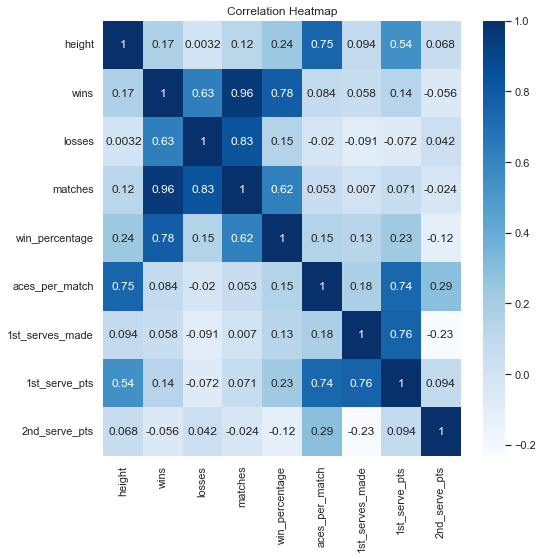

In [209]:
corr = player_data.corr()
sb.set(rc={'figure.figsize':(8,8)})
sb.heatmap(corr, cmap="Blues", annot=True).set(title='Correlation Heatmap')

This figure displays the correlation coefficient between every pair of numeric variables. The darker the color of a square, the more positively correlated those two variables are, and the lighter the color, the less correlated those two variables are. It appears that aces per match vs. height, wins vs. win percentage, matches vs. losses, aces per match vs. 1st serve points won, and 1st serves made vs. 1st serve points won all have high positive correlations. Some of the trends are to be expected (i.e. wins vs. win percentage), but it could be interesting to observe the relationship between win percentage vs. height and aces per match vs. height. None of the variables appear to follow a strong negative correlation.

Let's make a scatter plot of win percentage vs. height:

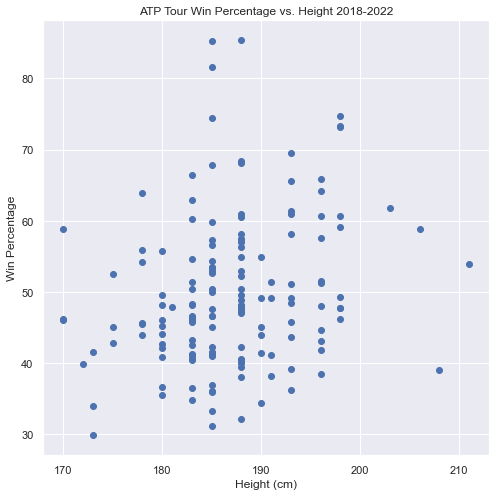

In [163]:
plt.figure(figsize=(8,8))
plt.scatter(player_data['height'], player_data['win_percentage'])
plt.title('ATP Tour Win Percentage vs. Height 2018-2022')
plt.xlabel('Height (cm)')
plt.ylabel('Win Percentage')
plt.show()

It looks like the data points are somewhat positively correlated. Let's try fitting a least-squares regression line. We are assuming that there exists a linear relationship between the two variables and that the residuals are normally distributed.

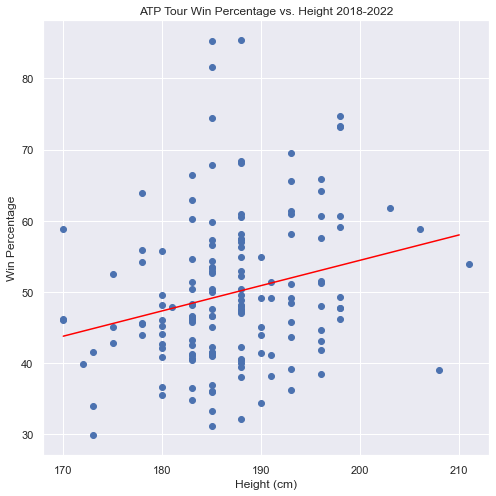

In [196]:
plt.figure(figsize=(8,8))
plt.scatter(player_data['height'], player_data['win_percentage'])
plt.title('ATP Tour Win Percentage vs. Height 2018-2022')
plt.xlabel('Height (cm)')
plt.ylabel('Win Percentage')
# Fitting a regression line
z = np.polyfit(player_data['height'], player_data['win_percentage'], 1)
p = np.poly1d(z)
xp = np.linspace(170, 210, 100)
plt.plot(xp, p(xp), color='red')
plt.show()

Let's look at the equation for this line.

In [165]:
print(p)

 
0.3558 x - 16.7


## Win Percentage = 0.3558 * Height - 16.7

So for every increase of 1 cm in a player's height, we can expect their win percentage to increase by about 0.36 percent.

While this gives us an estimate for win percentages based on height, we also want to know how strong this correlation is.

In [166]:
model = smf.ols(formula="win_percentage ~ height", data=player_data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         win_percentage   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     9.256
Date:                Thu, 15 Dec 2022   Prob (F-statistic):            0.00277
Time:                        15:48:12   Log-Likelihood:                -573.48
No. Observations:                 153   AIC:                             1151.
Df Residuals:                     151   BIC:                             1157.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -16.7002     21.874     -0.763      0.4

Looks like the r-squared value is 0.058, which means that the correlation coefficient is about sqrt(0.058) = 0.24.
This is a weak correlation, but it does not mean that height has no effect on a player's performance. It appears that while height does have an effect on a player's success on the ATP Tour, the effect is not substantial.

In addition, while the p-value for the intercept was quite high (0.446), the p-value for the slope is low enough for it to be considered significant (0.003). Using a significance level of 0.05, we can drop the intercept estimate but keep the slope estimate in our model. As a result, the model may only be somewhat accurate for predicting a player's win percentage based solely on their height.

Let's look at a histogram of the residuals to see if the normality assumption holds.

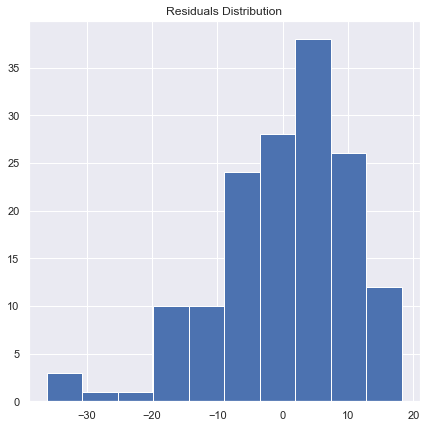

In [211]:
plt.figure(figsize=(7,7))
residuals = p(player_data['height']) - player_data['win_percentage']
plt.hist(residuals)
plt.title('Residuals Distribution')
plt.show()

It looks like the residuals are a little left-skewed, but for the most part normally distributed.

Perhaps height is more correlated with an in-game metric such as average number of aces made per match. An ace is when the returner does not make contact with the ball after the opponent serves.

Let's try plotting average aces per match vs. height.

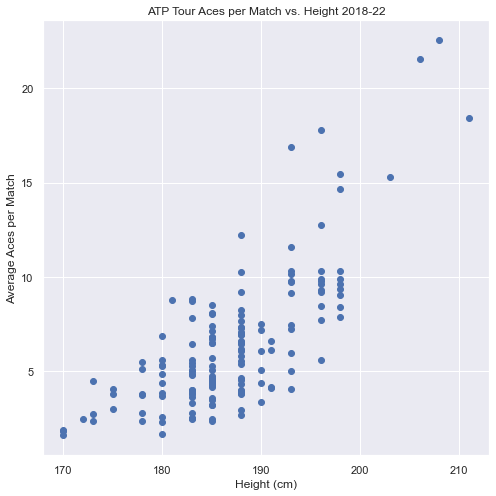

In [167]:
plt.figure(figsize=(8,8))
plt.scatter(player_data['height'], player_data['aces_per_match'])
plt.title('ATP Tour Aces per Match vs. Height 2018-22')
plt.xlabel('Height (cm)')
plt.ylabel('Average Aces per Match')
plt.show()

The data appears to have a strong positive correlation. Let's fit a Linear Regression model onto these points. This time however, we can try splitting the data into a training and testing set to see how well the model performs on unseen data. I will use 42 as an arbitrary random state so that the results are replicable. Note that although the number of aces a player makes per match is a discrete value, we are dealing with averages here, which are continuous.

First divide the data into a 80/20 train/test split:

In [202]:
X_train, X_test, y_train, y_test = train_test_split(player_data['height'], player_data['aces_per_match'], test_size=0.2, random_state=42)
print('Training Set Size: ' + str(len(X_train)))
print('Testing Set Size: ' + str(len(X_test)))

Training Set Size: 122
Testing Set Size: 31


So there are 122 players in the training set, and 31 players in the testing set.

Let's make a scatter plot of just the training set data:

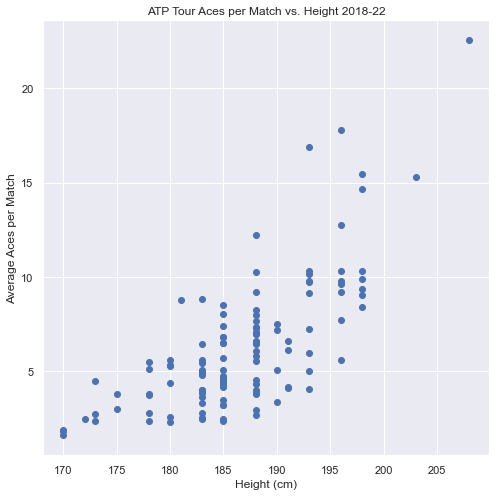

In [171]:
plt.figure(figsize=(8,8))
plt.scatter(X_train, y_train)
plt.title('ATP Tour Aces per Match vs. Height 2018-22')
plt.xlabel('Height (cm)')
plt.ylabel('Average Aces per Match')
plt.show()

The data still appears to have a strong positive correlation. We can fit a regression model onto this training set.

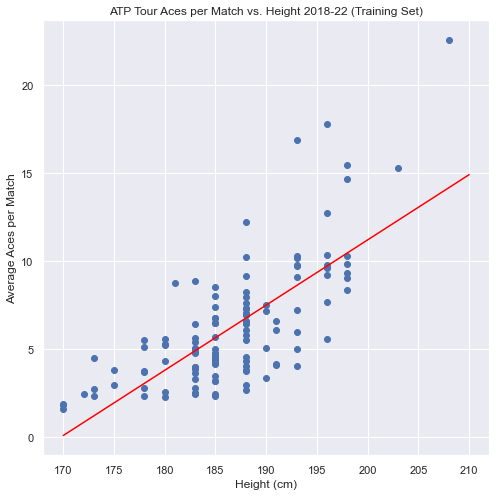

In [181]:
plt.figure(figsize=(8,8))
plt.scatter(X_train, y_train)
plt.title('ATP Tour Aces per Match vs. Height 2018-22 (Training Set)')
plt.xlabel('Height (cm)')
plt.ylabel('Average Aces per Match')
# Fitting a regression line
z = np.polyfit(X_train, y_train, 1)
p = np.poly1d(z)
xp = np.linspace(170, 210, 100)
plt.plot(xp, p(xp), color='red')
plt.show()

Let's look at the equation for the linear model.

In [173]:
print(p)

 
0.3702 x - 62.84


## Average aces per match = 0.3702 * Height - 62.84

So on average, we can expect an ATP player to make one more ace per match for every 3 cm taller they are.

Let's see how strong this correlation is for the testing set:

In [179]:
model2 = smf.ols(formula="aces_per_match ~ height", data=pd.merge(X_train, y_train, right_index=True, left_index=True)).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:         aces_per_match   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     132.6
Date:                Thu, 15 Dec 2022   Prob (F-statistic):           4.05e-21
Time:                        16:06:11   Log-Likelihood:                -281.44
No. Observations:                 122   AIC:                             566.9
Df Residuals:                     120   BIC:                             572.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -62.8374      6.004    -10.466      0.0

The r-squared value is 0.525, which means that the correlation coefficient is about 0.72, which is a significantly stronger correlation than win percentage vs. height. The p-values for the slope and intercept estimates are also very small (close to zero), so we can have high confidence in the predictions made by this model.

Let's see how well our model performs on the testing set by calculating the R-sqaured value.

In [203]:
clf = LinearRegression()
clf.fit(np.array(X_train).reshape((-1,1)),y_train)
r_squared = clf.score(np.array(X_test).reshape((-1,1)), y_test)
print('R^2 Value: ' + str(r_squared))

R^2 Value: 0.6452951421302116


The score function here calculates the r-squared value. The r-squared value for the model's predictions on the testing set is 0.645, or a correlation coefficient of about 0.80. So our model performed even better on the testing set than it did on the training set. Another interpretation of the r-squared value is that 64.5 percent of the variance in the average aces per match can be explained by the height variable.

Let's plot the regression line with the testing set data and compare it to the regression line with the training set data.

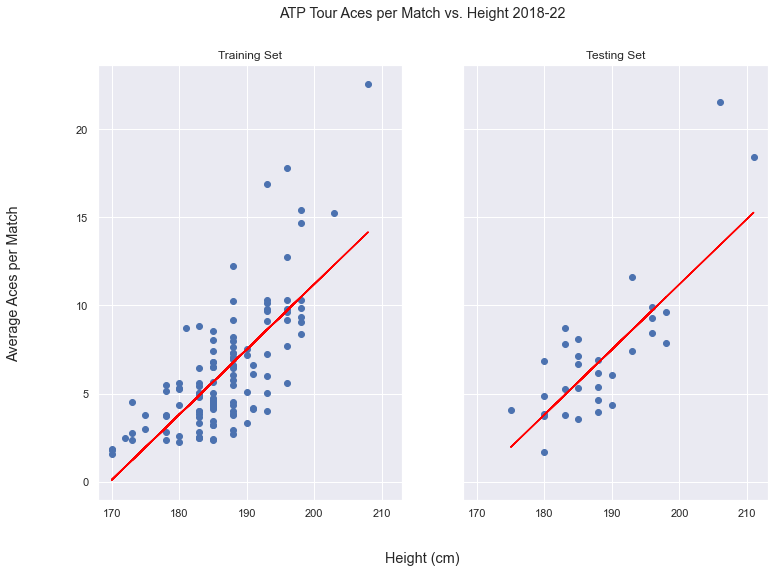

In [186]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8), sharey=True, sharex=True)
fig.suptitle('ATP Tour Aces per Match vs. Height 2018-22')
ax1.scatter(X_train, y_train)
ax2.scatter(X_test, y_test)
ax1.plot(X_train, clf.predict(np.array(X_train).reshape((-1,1))), color='red')
ax2.plot(X_test, clf.predict(np.array(X_test).reshape((-1,1))), color='red')
ax1.set_title('Training Set')
ax2.set_title('Testing Set')
fig.supxlabel('Height (cm)')
fig.supylabel('Average Aces per Match')
plt.show()

The regression line does appear to fit the testing set slightly better than the training set. Perhaps a performance metric such as mean absolute error would give us some insight into how well the model fits.

Let's look at the mean absolute error on the testing set:

In [204]:
print('Mean Absolute Error: ' + str(mean_absolute_error(y_test, clf.predict(np.array(X_test).reshape((-1,1))))))

Mean Absolute Error: 1.8251419056726872


So on average, a prediction made by the regression line on the testing set data is only 1.825 units (aces) away from the true value. I would say that this model should perform reasonably well given unseen data.

Finally, let's try plotting aces per match and win percentage:

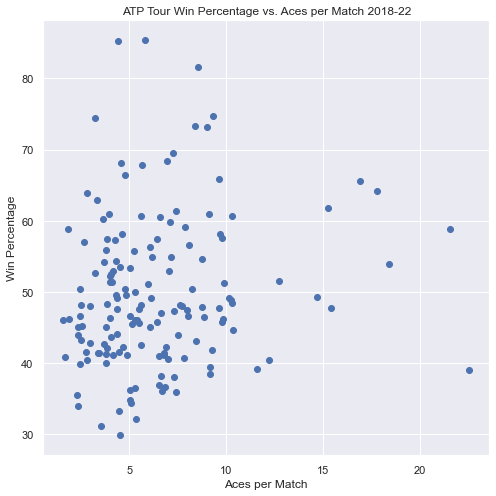

In [188]:
plt.figure(figsize=(8,8))
plt.scatter(player_data['aces_per_match'], player_data['win_percentage'])
plt.title('ATP Tour Win Percentage vs. Aces per Match 2018-22')
plt.xlabel('Aces per Match')
plt.ylabel('Win Percentage')
plt.show()

As we can see, the relationship here does not appear to be linear. Being able able to serve more aces does not necessarily indicate that a player will be more successful on the tour.

## Linear Regression Summary

From this section, we can see that while being taller does have its advantages in tennis (mainly in serving), it is not the only factor that determines a player's success on the ATP Tour. It makes sense for taller players to be better servers, as they are able to hit the ball from a higher trajectory, allowing them to generate more speed on the ball. However, while being a good server is definitely an advantage in tennis, it is not the only aspect of the game that players need to excel in to win matches. In tennis, players take turns serving every service game. While being able to consistently hold your own serve is great, in order to win matches, one must break their opponent's serve, or win games as the receiver. Another important aspect is footwork and mobility, and being too tall can often hinder a player's mobility on-court. So while serving is a very important aspect of the game, it is not the only factor to consider when predicting a player's chances of winning.

# Part 4: Hypothesis Testing

In this part, I will conduct a difference of means t-test to see if left-handed players really do have a significant advantage over right-handed players.

Let's first see how many left and right players there are:

In [190]:
player_data.value_counts('hand')

hand
R    132
L     21
dtype: int64

So there are 132 right-handed players and 21 left-handed players.

Group the players by their dominant hand and look at their average win percentage for the year:

In [191]:
player_data.groupby(['hand']).mean()

,height,wins,losses,matches,win_percentage,aces_per_match,1st_serves_made,1st_serve_pts,2nd_serve_pts
hand,,,,,,,,,
L,184.857143,70.285714,69.00000,139.285714,47.590694,5.325884,51.166398,35.779872,15.398260
R,187.265152,75.159091,65.44697,140.606061,50.153993,6.608207,50.599990,36.331458,15.729592


It appears that right-handed players actually have a higher average win rate than left-handed players. We can conduct a t-test to see if this different is significant.

There are a few assumptions that we must make before conducting a t-test. Firstly, we assume that the two populations (win percentages of left and right-handed players) are independent and both follow a normal distribution. We also assume that the data is collected from a simple random sample where we are sampling with replacement. Lastly, we assume that the variances of the two populations are equal.

We want the assumptions of the t-test to hold, so let's first check if the distributions of win percentages for left and right-handed players follow a normal distribution.

Plot histograms of win percentagees for each hand:

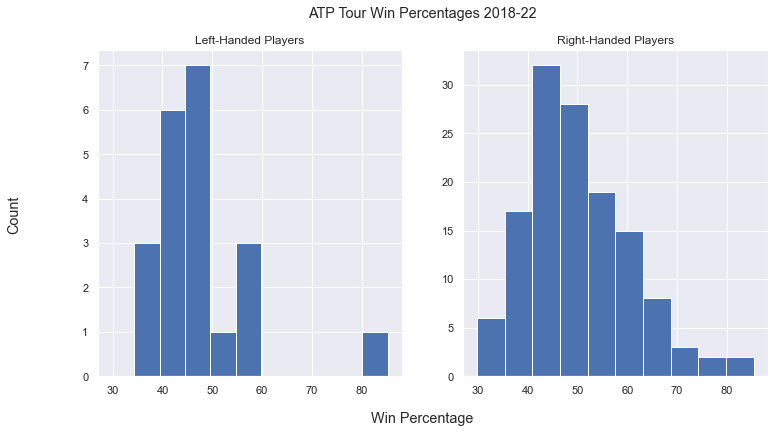

In [208]:
lefties = player_data[player_data['hand'] == 'L']
righties = player_data[player_data['hand'] == 'R']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), sharex=True)
fig.suptitle('ATP Tour Win Percentages 2018-22')
ax1.hist(lefties['win_percentage'])
ax2.hist(righties['win_percentage'])
ax1.set_title('Left-Handed Players')
ax2.set_title('Right-Handed Players')
fig.supxlabel('Win Percentage')
fig.supylabel('Count')
plt.show()

It appears that both distributions are a little bit right-skewed, but are still mostly normal. This is to be expected because professional tennis has been dominated by a select few players for the most part of the part of the past 15 years. However, let us proceed for now.

Reference: Dominance of the Big 3
https://en.wikipedia.org/wiki/Big_Three_(tennis)

Let's also check the equality of variance assumption by comparing the standard deviations.

In [192]:
lefties['win_percentage'].std()

10.614195609282786

In [193]:
righties['win_percentage'].std()

10.613519292731281

The standard deviations are nearly equal, so we can now proceed with the t-test.

Let us now conduct a difference of means t-test.

Null Hypothesis: mu1 = mu2
Alternative Hypothesis: mu1 != mu2

In [194]:
ss.ttest_ind(lefties['win_percentage'], righties['win_percentage'])

Ttest_indResult(statistic=-1.0279858573386933, pvalue=0.30560035319150813)

The t-test resulted in a relatively high p-value (0.31), so we cannot reject our null hypothesis using a threshold of alpha = 0.05. We conclude that the average win percentage for left-handed players is not significantly different from that of right-handed players. Another important consideration is that the sample size for left-handed players was much smaller than for right-handed players (21 vs. 132), so the results may be more accurate if there were more samples for left-handed players.

Why did these results not meet our expectations? A possible explanation is that since professional tennis players have been playing tennis their entire lives, most have probably faced left-handed opponents before and know of a good strategy to compete against them. Thus, the advantage is not as obvious in most cases. The left-handed advantage may be more apparent in amateur and recreational tennis since the players there are less experienced.

# Part 5: Conclusion

In this project, I have gone through the stages of the data science pipeline in order to test whether certain physical attributes really do give professional tennis players an advantage over their competitors.

We began by exploring the data to find variables which have a linear relationship. This led to the use of Linear Regression to compare metrics such as Win Percentage vs. Height and Aces per Match vs. Height. We found that Aces per Match vs. Height was much more correlated than Win Percentage vs. Height. We saw that being taller does have major advantages when it comes to serving, as we saw in the strong linear relationship between Aces per Match and Height. Thus, it appears that while being taller does give players an advantage, it is not as strong of an advantage as we may have thought.

We then tested the theory of whether left-handed players really do have an advantage over right-handed players. It was observed that the difference in average win percentages is not obvious and that left and right-handed players had similar averages in nearly all the performance metrics. This indicates that being left-handed does not necessarily give a player an obvious advantage against a right-handed player. It seems that success is more dependent on other aspects of the game, such as serving, mobility, and consistency.

Ultimately, it was interesting to apply the methods I learned in class and from the projects to a real-world topic that I am interested in. If given more time, I may experiment with other prediction methods and models in order to find more nuanced trends and relationships.